In [11]:
import pandas as pd
import numpy as np

In [12]:
pair = "EURUSD"

In [13]:
df = pd.read_csv(f'../data/raw_{pair}.csv')

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from ta.trend import MACD, SMAIndicator, PSARIndicator
from ta.momentum import RSIIndicator, StochasticOscillator, AwesomeOscillatorIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.others import DailyReturnIndicator
from pykalman import KalmanFilter
import plotly.express as px

def apply_kalman_filter(series):
    kf = KalmanFilter(initial_state_mean=series.iloc[0], n_dim_obs=1)
    state_means, _ = kf.filter(series.values)
    return pd.Series(state_means.flatten(), index=series.index)

def add_indicators(df):
    # Parabolic SAR - ปรับให้ไวขึ้นสำหรับไทม์เฟรมสั้น
    psar = PSARIndicator(high=df['high'], low=df['low'], close=df['close'], 
                        step=0.015, max_step=0.15)
    df['psar'] = psar.psar()
    df['psar_trend'] = np.where(df['close'] > df['psar'], 1, -1)  # 1 = uptrend, -1 = downtrend

    # RSI - ใช้ค่า 7 สำหรับไทม์เฟรม 1 นาที
    rsi = RSIIndicator(close=df['close'], window=12)
    df['rsi'] = rsi.rsi()

    # Apply Kalman filter to close price with modified transition variance
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=df['close'].iloc[0],
        initial_state_covariance=1,
        observation_covariance=1.0,
        transition_covariance=0.436  # << Controls smoothness
    )
    state_means, _ = kf.filter(df['close'].values)
    df['kalman'] = state_means.flatten()

    return df

def generate_signals(df):
    signals = pd.DataFrame(index=df.index)
    signals['price'] = df['close']
    signals['psar_signal'] = df['psar_trend']
    signals['rsi_signal'] = 0
    signals.loc[(df['rsi'] < 32), 'rsi_signal'] = 1  # ภาวะขายมากเกินไป (Oversold)
    signals.loc[(df['rsi'] > 79), 'rsi_signal'] = -1 # ภาวะซื้อมากเกินไป (Overbought)
    signals.loc[(df['rsi'] > 50) & (df['rsi'] < 79), 'rsi_signal'] = 1  # ภาวะขายมากเกินไป (Oversold)
    signals.loc[(df['rsi'] > 32) & (df['rsi'] < 50), 'rsi_signal'] = -1  # ภาวะซื้อมากเกินไป (Overbought)
    # Signal generation
    signals['kalman_signal'] = 0
    signals.loc[(df['close'] > df['kalman']), 'kalman_signal'] = 1
    signals.loc[(df['close'] < df['kalman']), 'kalman_signal'] = -1

    signals['total_signal'] = (signals['rsi_signal']+signals['psar_signal']+signals['kalman_signal']) # +signals['rsi_signal']+signals['psar_signal']+signals['kalman_signal']


    # สัญญาณสุดท้าย: 1 = ซื้อ (Call), -1 = ขาย (Put), 0 = ไม่ทำอะไร
    signals['entry_signal'] = 0
    signals.loc[signals['total_signal'] >= 3, 'entry_signal'] = 1  # สัญญาณซื้อที่แข็งแกร่ง
    signals.loc[signals['total_signal'] <= -3, 'entry_signal'] = -1  # สัญญาณขายที่แข็งแกร่ง

    signals['actual_signal'] = 0
    signals.loc[df['open'] > df['close'], 'actual_signal'] = -1  # แท่งแดง → PUT
    signals.loc[df['open'] < df['close'], 'actual_signal'] = 1   # แท่งเขียว → CALL
    return signals  # Return the last signal

Total Trades: 245
Max Win Streak: 7
Max Lose Streak: 7
Win Rate: 49.80%
Streak 1: Lose 1 times
Streak 2: Win 1 times
Streak 3: Lose 2 times
Streak 4: Win 1 times
Streak 5: Lose 2 times
Streak 6: Win 5 times
Streak 7: Lose 1 times
Streak 8: Win 1 times
Streak 9: Lose 2 times
Streak 10: Win 1 times
Streak 11: Lose 1 times
Streak 12: Win 2 times
Streak 13: Lose 2 times
Streak 14: Win 3 times
Streak 15: Lose 2 times
Streak 16: Win 1 times
Streak 17: Lose 2 times
Streak 18: Win 3 times
Streak 19: Lose 1 times
Streak 20: Win 3 times
Streak 21: Lose 1 times
Streak 22: Win 2 times
Streak 23: Lose 1 times
Streak 24: Win 3 times
Streak 25: Lose 3 times
Streak 26: Win 3 times
Streak 27: Lose 1 times
Streak 28: Win 1 times
Streak 29: Lose 2 times
Streak 30: Win 2 times
Streak 31: Lose 4 times
Streak 32: Win 2 times
Streak 33: Lose 2 times
Streak 34: Win 1 times
Streak 35: Lose 2 times
Streak 36: Win 1 times
Streak 37: Lose 1 times
Streak 38: Win 2 times
Streak 39: Lose 1 times
Streak 40: Win 1 tim

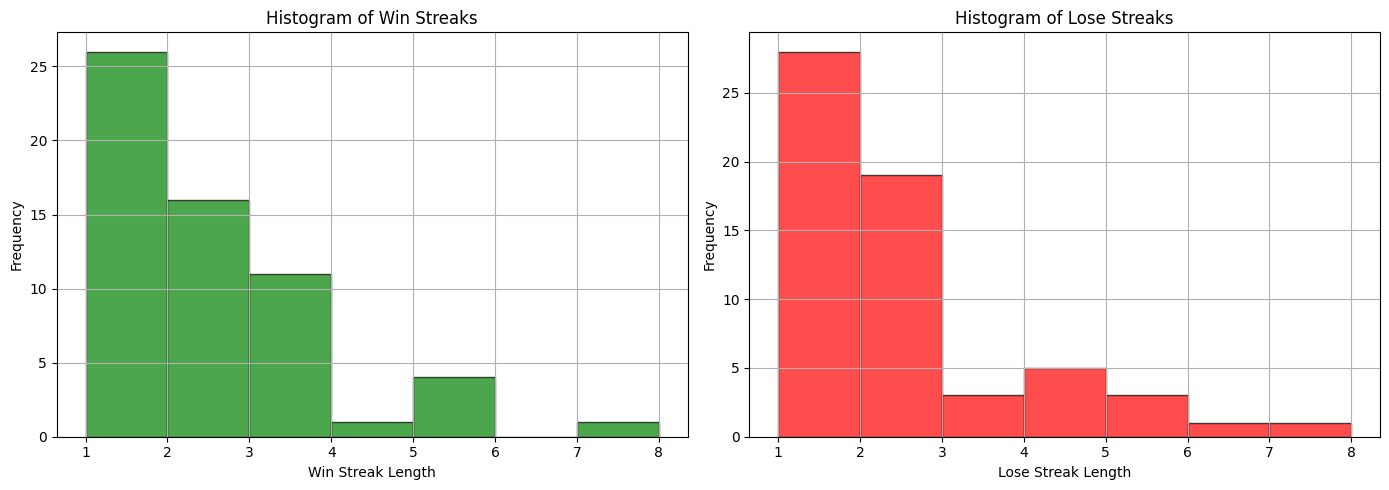

In [17]:
def backtest_binary_options(signals, expiry_minutes=5):
    """
    ทดสอบย้อนหลังสำหรับไบนารีออปชั่นที่มีเวลาหมดอายุ
    """
    results = pd.DataFrame(index=signals.index)
    results['price'] = signals['price']
    results['signal'] = signals['entry_signal']
    
    results['entry_price'] = np.nan
    results['expiry_price'] = np.nan
    results['win'] = np.nan
    total_trades = 0
    
    for i in range(0, len(results) - expiry_minutes, 2):
        if results.iloc[i]['signal'] != 0:
            total_trades += 1
            entry_price = results.iloc[i]['price']
            results.iloc[i, results.columns.get_loc('entry_price')] = entry_price
            
            expiry_price = results.iloc[i + expiry_minutes]['price']
            results.iloc[i, results.columns.get_loc('expiry_price')] = expiry_price
            
            if results.iloc[i]['signal'] == 1:
                win = 1 if expiry_price > entry_price else 0
            else:
                win = 1 if expiry_price < entry_price else 0
                
            results.iloc[i, results.columns.get_loc('win')] = win
    
    win_rate = results['win'].mean() * 100

    # Streak analysis
    max_win_streak = 0
    max_lose_streak = 0
    current_win_streak = 0
    current_lose_streak = 0
    streaks = []
    current_streak = 0
    current_result = None

    for result in results['win'].dropna():
        if result == current_result:
            current_streak += 1
        else:
            if current_result is not None:
                streaks.append((current_result, current_streak))
            current_result = result
            current_streak = 1
        
        if result == 1:
            current_win_streak += 1
            current_lose_streak = 0
        else:
            current_lose_streak += 1
            current_win_streak = 0
        
        max_win_streak = max(max_win_streak, current_win_streak)
        max_lose_streak = max(max_lose_streak, current_lose_streak)

    if current_result is not None:
        streaks.append((current_result, current_streak))
    
    return results, win_rate, max_win_streak, max_lose_streak, total_trades, streaks


def plot_streak_histogram(streaks):
    """
    แสดง histogram ของ streaks แยก win และ lose
    """
    win_streaks = [s for r, s in streaks if r == 1]
    lose_streaks = [s for r, s in streaks if r == 0]

    max_streak_len = max(win_streaks + lose_streaks, default=0)

    plt.figure(figsize=(12, 6))
    bins = range(1, max_streak_len + 2)

    plt.hist(win_streaks, bins=bins, alpha=0.6, label='Win Streaks', color='green', edgecolor='black')
    plt.hist(lose_streaks, bins=bins, alpha=0.6, label='Lose Streaks', color='red', edgecolor='black')

    plt.title("Distribution of Win/Lose Streak Lengths")
    plt.xlabel("Streak Length")
    plt.ylabel("Frequency")
    plt.xticks(bins)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_separated_streak_histograms(streaks):
    """
    แสดง histogram แยก win streak และ lose streak
    """
    win_streaks = [s for r, s in streaks if r == 1]
    lose_streaks = [s for r, s in streaks if r == 0]

    max_win_len = max(win_streaks, default=0)
    max_lose_len = max(lose_streaks, default=0)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Win streak histogram
    bins_win = range(1, max_win_len + 2)
    axes[0].hist(win_streaks, bins=bins_win, color='green', edgecolor='black', alpha=0.7)
    axes[0].set_title('Histogram of Win Streaks')
    axes[0].set_xlabel('Win Streak Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xticks(bins_win)
    axes[0].grid(True)

    # Lose streak histogram
    bins_lose = range(1, max_lose_len + 2)
    axes[1].hist(lose_streaks, bins=bins_lose, color='red', edgecolor='black', alpha=0.7)
    axes[1].set_title('Histogram of Lose Streaks')
    axes[1].set_xlabel('Lose Streak Length')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xticks(bins_lose)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_streak_timeline(results):
    """
    แสดงผล win/lose แบบ timeline โดยใช้ Plotly
    """
    streak_df = results[['win']].dropna().copy()
    streak_df['time'] = streak_df.index
    streak_df['outcome'] = streak_df['win'].map({1: 'Win', 0: 'Lose'})
    streak_df['streak_group'] = None

    # สร้าง group เดียวกันสำหรับ streak เดียวกัน
    group_id = 0
    prev_result = None
    for i, val in streak_df['win'].items():
        if val != prev_result:
            group_id += 1
        streak_df.loc[i, 'streak_group'] = group_id
        prev_result = val

    # Plot
    fig = px.scatter(
        streak_df,
        x='time',
        y='streak_group',
        color='outcome',
        symbol='outcome',
        title='Win/Lose Streak Timeline',
        labels={'streak_group': 'Streak Group'},
        height=400
    )

    fig.update_traces(marker=dict(size=10))
    fig.update_layout(yaxis=dict(tickvals=[]))  # ซ่อน y-axis ของ streak group
    fig.show()

    
def main():
    # โหลดข้อมูล
    df = pd.read_csv(f'../data/raw_{pair}.csv')
    
    # หรือสร้างข้อมูลจำลอง
    np.random.seed(42)
    n = 1000  # จำนวนแท่งเทียน 1 นาที
    
    dates = pd.date_range('2023-01-01', periods=n, freq='1min')
    price_o = df['open'].values #100 + np.cumsum(np.random.normal(0, 0.3, n))
    price_c = df['close'].values
    high = df['high'].values #price + np.random.uniform(0, 1, n)
    low = df['low'].values #price - np.random.uniform(0, 1, n)
    volume = df['volume'].values
    
    df = pd.DataFrame({
        'open': price_o,
        'high': high,
        'low': low,
        'close': price_c,
        'volume': volume #np.random.uniform(1000, 5000, n)
    }, index=dates)
    
    # เพิ่มอินดิเคเตอร์
    df = add_indicators(df)
    
    # สร้างสัญญาณ
    signals = generate_signals(df)
    
    results, win_rate, mw, ml, total_trade, streaks = backtest_binary_options(signals, expiry_minutes=1)

    print(f"Total Trades: {total_trade}")
    print(f"Max Win Streak: {mw}")
    print(f"Max Lose Streak: {ml}")
    print(f"Win Rate: {win_rate:.2f}%")

    # แสดง streak ทั้งหมดแบบข้อความ
    for i, (result, streak_len) in enumerate(streaks, 1):
        outcome = 'Win' if result == 1 else 'Lose'
        print(f"Streak {i}: {outcome} {streak_len} times")

    # แสดง histogram streaks
    plot_separated_streak_histograms(streaks)
    plot_streak_timeline(results)



if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from ta.momentum import RSIIndicator
from ta.trend import PSARIndicator
from pykalman import KalmanFilter


def apply_kalman_filter(price_series, process_variance=1e-5, observation_variance=1e-1):
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=price_series.iloc[0],
        initial_state_covariance=1,
        transition_covariance=process_variance,
        observation_covariance=observation_variance
    )
    state_means, _ = kf.filter(price_series.values)
    return pd.Series(state_means.flatten(), index=price_series.index)


def add_indicators(df, psar_step=0.02, psar_max=0.2, rsi_window=14, kalman_cov=1e-1):
    df = df.copy()
    df['rsi'] = RSIIndicator(df['close'], window=rsi_window).rsi()
    psar = PSARIndicator(df['high'], df['low'], df['close'], step=psar_step, max_step=psar_max)
    df['psar'] = psar.psar()
    df['kalman'] = apply_kalman_filter(df['close'], observation_variance=kalman_cov)
    return df


def generate_signals(df):
    df = df.copy()
    df['signal'] = 0
    # Long signal
    df.loc[
        (df['rsi'] < 30) &
        (df['close'] > df['psar']) &
        (df['close'] > df['kalman']),
        'signal'
    ] = 1
    # Short signal
    df.loc[
        (df['rsi'] > 70) &
        (df['close'] < df['psar']) &
        (df['close'] < df['kalman']),
        'signal'
    ] = -1
    return df


def backtest_binary_options(df, expiry=1):
    df = df.copy()
    df['win'] = 0

    for i in range(len(df) - expiry):
        if df['signal'].iloc[i] == 1:
            df.loc[df.index[i], 'win'] = 1 if df['close'].iloc[i + expiry] > df['close'].iloc[i] else -1
        elif df['signal'].iloc[i] == -1:
            df.loc[df.index[i], 'win'] = 1 if df['close'].iloc[i + expiry] < df['close'].iloc[i] else -1

    df.dropna(inplace=True)

    total_trades = (df['win'] != 0).sum()
    win_rate = (df['win'] == 1).sum() / total_trades * 100 if total_trades > 0 else 0

    max_win_streak = (df['win'] == 1).astype(int).groupby((df['win'] != 1).cumsum()).sum().max()
    max_lose_streak = (df['win'] == -1).astype(int).groupby((df['win'] != -1).cumsum()).sum().max()

    return df, win_rate, max_win_streak, max_lose_streak, total_trades


def optimize_parameters(df, n_trials=100):
    def objective(trial):
        psar_step = trial.suggest_float('psar_step', 0.01, 0.1)
        psar_max = trial.suggest_float('psar_max', 0.1, 0.5)
        rsi_window = trial.suggest_int('rsi_window', 5, 20)
        kalman_cov = trial.suggest_float('kalman_cov', 1e-3, 1.0)

        df_ind = add_indicators(df, psar_step, psar_max, rsi_window, kalman_cov)
        df_sig = generate_signals(df_ind)
        results, win_rate, max_win_streak, max_lose_streak, total_trades = backtest_binary_options(df_sig)

        if total_trades < 30 or max_lose_streak > 4:
            return 0  # ลงโทษ

        return win_rate

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print("Best trial:", study.best_trial)
    return study.best_params


def main():
    pair = "EURUSD"
    df_raw = pd.read_csv(f'../data/raw_{pair}.csv')
    # df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
    # df_raw.set_index('datetime', inplace=True)
    # df_raw.dropna(inplace=True)

    print("🔍 กำลังหา parameter ที่ดีที่สุดด้วย Optuna...")
    best_params = optimize_parameters(df_raw, n_trials=100)

    print("\n✅ ใช้พารามิเตอร์ที่ดีที่สุดในการทดสอบกลยุทธ์:")
    print(best_params)

    df = add_indicators(
        df_raw,
        psar_step=best_params['psar_step'],
        psar_max=best_params['psar_max'],
        rsi_window=best_params['rsi_window'],
        kalman_cov=best_params['kalman_cov']
    )
    df = generate_signals(df)

    results, win_rate, max_win_streak, max_lose_streak, total_trades = backtest_binary_options(df)

    print(f"\n📊 ผลลัพธ์กลยุทธ์ Backtest สำหรับ {pair}:")
    print(f"- Win Rate: {win_rate:.2f}%")
    print(f"- Max Win Streak: {max_win_streak}")
    print(f"- Max Lose Streak: {max_lose_streak}")
    print(f"- Total Trades: {total_trades}")

    results['cumulative_win'] = results['win'].fillna(0).cumsum()
    results['cumulative_win'].plot(title='📈 Cumulative Wins Over Time', figsize=(12, 6))
    plt.grid()
    plt.show()


if __name__ == "__main__":
    main()


In [ ]:
import pytz
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(f'data/raw_{pair}.csv')

# แปลงเวลาเป็นเขตเวลาประเทศไทย
df['datetime'] = pd.to_datetime(df['time'])  # สมมติว่าคอลัมน์ datetime มีอยู่ใน DataFrame
df['datetime_th'] = df['datetime'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')

# สร้างคอลัมน์ความผันผวน (Volatility)
df['volatility'] = df['high'] - df['low']

# พล็อตกราฟ
plt.figure(figsize=(12, 6))
plt.plot(df['datetime_th'], df['volatility'], label='Volatility', color='blue', alpha=0.7)
plt.title('Volatility Over Time (Thailand Time Zone)', fontsize=14)
plt.xlabel('Time (Thailand)', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()